By [Kevin Michalewicz](https://kevinmichalewicz.com) on Jan 2025

This notebook discusses interpretability in the context of LLM-GCN.

In [1]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from gcn_bf.utils.biology_utils import count_consecutive_secondary, is_in_cdr, get_epitope_members, get_paratope_members, get_antigen_only, get_variable_region_only, preprocess_interpretability
from gcn_bf.utils.torch_utils import load_pickle
from gcn_bf.utils.plot_utils import boxplot_delta_e, plot_consecutive_secondary, plot_prediction_errors

/Users/kevinmicha/anaconda3/envs/gcn-bagpype/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre-processing

In [17]:
# Getting test set indices
data_path = '../data/'
interpretability_path = 'interpretability_files/'
test_indices = np.load(data_path+'test_indices.npy')
pdb_codes = np.load(data_path+'pdb_codes.npy')
test_set = pdb_codes[test_indices]

# Obtaining corresponding sequences, secondary structure, diversity scores, chain lengths, and members of paratope and epitope
sequences = torch.load(data_path+'sequences.pt', 'rb')
sequences = [sequences[i] for i in test_indices]
residue_ids = list(np.load(interpretability_path+'residue_ids.npy'))

secondary = load_pickle(interpretability_path+'secondary_ag.pkl')
ds = load_pickle(interpretability_path+'conservation_scores.pkl')

heavy = [len(seq.split(':')[0]) for seq in sequences]
light = [len(seq.split(':')[1]) for seq in sequences]

paratope_epitope = torch.load(interpretability_path+'paratope_epitope.pt', 'rb')
paratope_epitope = [paratope_epitope.get(pdb, []) for pdb in test_set]

# Finally, we load the MSEs for sequence alone and when adding the graph path
mse = np.load(interpretability_path+'mse.npy')
mse_seq = np.load(interpretability_path+'mse_seq.npy')
errors = load_pickle(interpretability_path+'errors_with_antigen.pkl')
errors_seq = load_pickle(interpretability_path+'errors_with_antigen_seq.pkl')
delta_e, secondary_v, ds, heavy_v, light_v, epitope_m, paratope_m = preprocess_interpretability(errors, errors_seq, secondary, ds, heavy, light, paratope_epitope)

# For some cases we only need the antibody variable region or antigen only
delta_e_v = get_variable_region_only(delta_e, heavy, light, heavy_v, light_v)
errors_v = get_variable_region_only(errors, heavy, light, heavy_v, light_v)
errors_seq_v = get_variable_region_only(errors_seq, heavy, light, heavy_v, light_v)
delta_e_ag = get_antigen_only(delta_e, heavy, light)
secondary_ag = get_antigen_only(secondary, heavy, light)

## Prediction errors for each antibody position

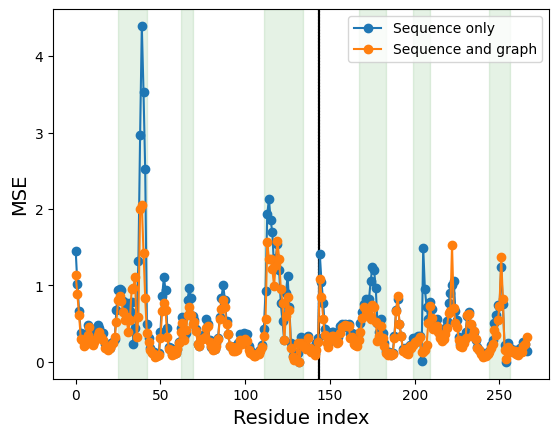

In [3]:
plot_prediction_errors(mse, mse_seq, residue_ids)

## $\Delta e$ against different variables

#### Antibody secondary structure

<Figure size 640x480 with 0 Axes>

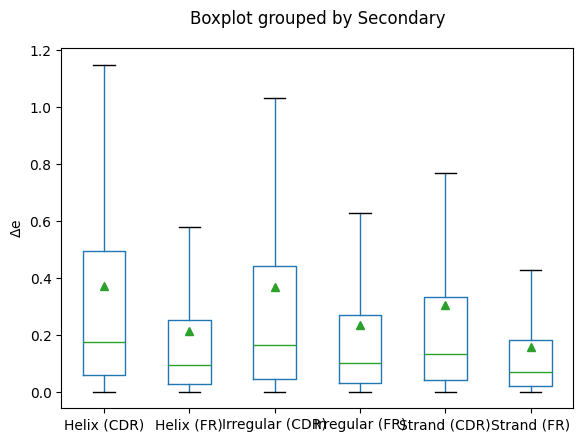

In [4]:
boxplot_delta_e(delta_e_v, secondary_v)

#### Antigen secondary structure

<Figure size 640x480 with 0 Axes>

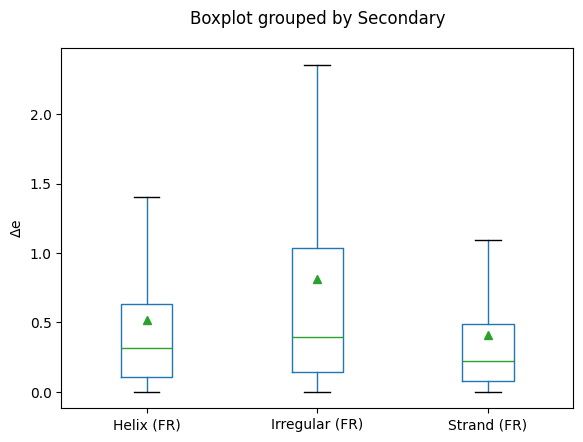

In [5]:
boxplot_delta_e(delta_e_ag, secondary_ag)

#### Diversity scores

0-1    8609
1-2    6922
>2     1855
Name: count, dtype: int64


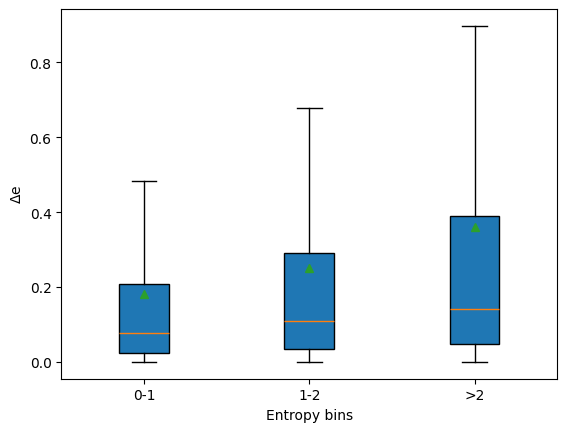

In [6]:
boxplot_delta_e(delta_e_v, ds, ind_class='entropy')

#### CDR vs Framework

<Figure size 640x480 with 0 Axes>

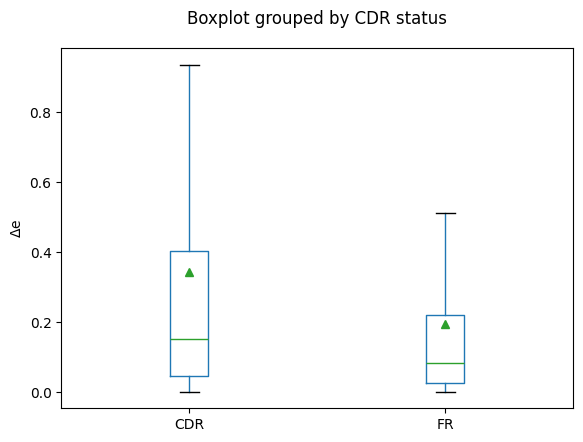

In [7]:
boxplot_delta_e(delta_e_v, secondary_v, ind_class='cdr_status')

#### Epitope membership

<Figure size 640x480 with 0 Axes>

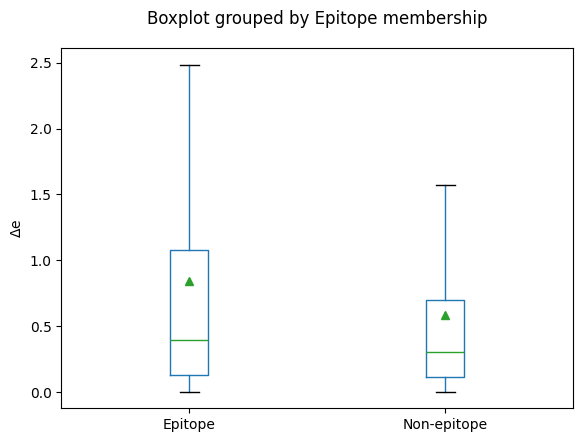

In [8]:
boxplot_delta_e(delta_e_ag, epitope_m, ind_class='epitope')

#### Paratope membership

<Figure size 640x480 with 0 Axes>

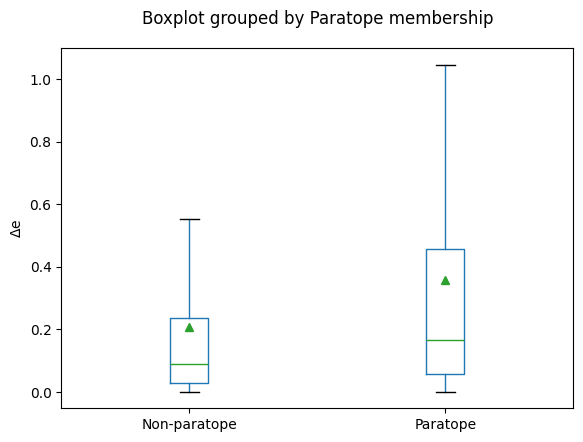

In [9]:
boxplot_delta_e(delta_e_v, paratope_m, ind_class='paratope')

## Consecutive secondary structure motifs

12 consecutive helix - FR: 4, CDR: 3, Total: 7
Average delta_e for 12 consecutive helix - FR: 0.5675001692349421, CDR: 0.5382487311500073, Total: 0.5549638386271128
11 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 11 consecutive helix - FR: 0, CDR: 0, Total: 0
10 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 10 consecutive helix - FR: 0, CDR: 0, Total: 0
9 consecutive helix - FR: 1, CDR: 3, Total: 4
Average delta_e for 9 consecutive helix - FR: 0.2443689151097917, CDR: 0.7106722081985531, Total: 0.5940963849263627
8 consecutive helix - FR: 0, CDR: 1, Total: 1
Average delta_e for 8 consecutive helix - FR: 0, CDR: 0.28589251008816063, Total: 0.28589251008816063
7 consecutive helix - FR: 1, CDR: 1, Total: 2
Average delta_e for 7 consecutive helix - FR: 1.119980445929936, CDR: 0.15527850176606858, Total: 0.6376294738480023
6 consecutive helix - FR: 9, CDR: 13, Total: 22
Average delta_e for 6 consecutive helix - FR: 0.10554178078719242, CDR: 0.28334826980

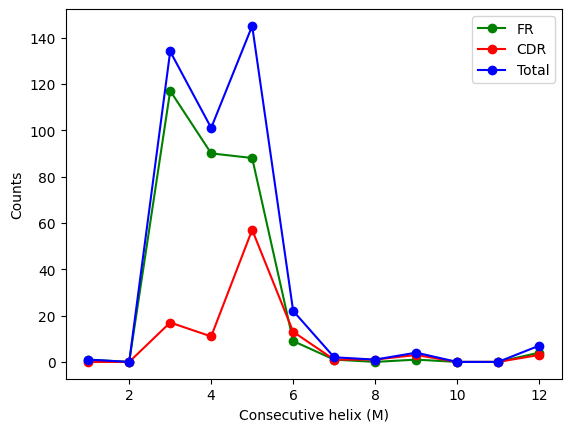

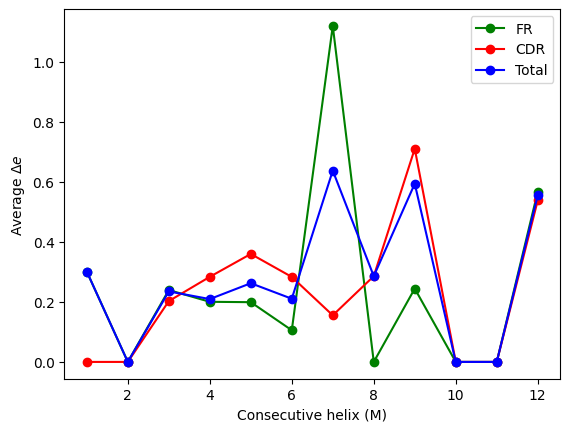

In [21]:
plot_consecutive_secondary(delta_e_v, secondary_v, secondary_type='helix')